# Uncertainty Quantification using Delete-d Jackknife

The Delete-d Jackknife is designed to provide prediction intervals using sampling techniques. This approach follows the methodology described in Giordano (2019), Wager & Hastie & Efron (2014) and Shao & Wun (1989)

### Pros:
-Improved Estimation of Variance

-Robustness

-Model Agnostic

-Simplicity

-Capacity to capture Aleatoric and Epistemic Uncertainty

### Cons:
-Assumptions and Limitations

-Potential for Overfitting

# Mathematical Approach Behind Delete-d Jackknife for Uncertainty Quantification

We begin by defining the OJK. Let $\hat{\theta} $ be the estimate of $\theta$ based on $ X_1, X_2, \ldots, X_n
$. If we omit  $ X_i $ and estimate $ \theta $ from the n - 1 remaining observations, we call this estimate the $i\text{-th}$ pseudoestimate, and we write it as $ \hat{\theta}_{(i)} $.

The jackknife does two things for us: It gives a variance estimate for $\hat{\theta} $, and it reduces the
bias in $\hat{\theta} $. We estimate the variance of $\hat{\theta} $ by:

$ \hat{V} = \frac{1}{n(n - 1)} \sum_{i=1}^n \left( p(i) - p(\cdot) \right)^2 = \frac{n - 1}{n} \sum_{i=1}^n \left( \hat{\theta}_{(i)} - \hat{\theta}(\cdot) \right)^2 $

Within this context, given the necessity of calculating $\hat{\theta}_{(1)}, \ldots, \hat{\theta}_{(n-1)}$, it is natural to instead
consider the estimator

$ \hat{\theta} = \frac{1}{n-1} \sum_{k=1}^{n-1} \hat{\theta}_{(k)} $


The same result can be achieved with little loss of accuracy, by estimating $ \theta $ from $ n-d $ observations, being $ {d} $ constant and chosen taking in consideration the size of the dataset, ${n}$. Now, the sample is divided into g mutually exclusive and independent groups of equal size, ${d}$. In order to mantain the correctness, every instance must be omitted once and only once resulting in a number of ${g} ({d}={n}/{g})$ jackknife samples, with a size of ${n} - {d}$ . This method is known as the Delete-d jackknife

Let $ \hat{\theta}_{(z)} $ denote $\hat{\theta} $ applied to the data set with subset z removed. The formula for the delete-d jackknife estimate of variance is given by:

$ \hat{V} = \frac{1}{g(g - 1)} \sum_{j=1}^g \left( p(j) - p(\cdot) \right)^2 = \frac{g - 1}{g} \sum_{j=1}^g \left( \hat{\theta}_{(j)} - \hat{\theta}(\cdot) \right)^2 $


### Step 1: Write import statements

In [1]:
import sys
sys.path.append("../../")

In [2]:
import numpy as np
from scipy.stats import gaussian_kde
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb

from common_uq import jackknife_predict, plot_uq_quality

### Step 2: Load and Pre-process dataset

The dataset comprises customer purchase information from an e-commerce platform. It contains 1,500 entries and 9 columns, detailing various attributes related to customer demographics, their interactions with the platform, and purchase behaviors.

#### Data Dictionary

1. **Age**: Customer's age (integer).
2. **Gender**: Customer's gender (integer, where 0 indicates female and 1 indicates male).
3. **AnnualIncome**: Customer's annual income (float).
4. **NumberOfPurchases**: The number of purchases made by the customer (integer).
5. **ProductCategory**: Category of the product purchased (integer, assumed to be categorical).
6. **TimeSpentOnWebsite**: The total time (in minutes) the customer spent on the website (float).
7. **LoyaltyProgram**: Indicates if the customer is part of a loyalty program (integer, where 0 indicates not part of the program and 1 indicates part of the program).
8. **DiscountsAvailed**: The number of discounts availed by the customer (integer).
9. **PurchaseStatus**: Indicates whether a purchase was made (integer, where 0 indicates no purchase and 1 indicates a purchase).

#### Initial Data Analysis

##### Data Types and Non-Null Values

- The dataset contains 1,500 rows and 9 columns.
- All columns have non-null values.
- Data types include integers (7 columns) and floats (2 columns).

#### Sample Data


In [3]:
df=pd.read_csv("customer_purchase_data.csv")
X = df[['Age', 'Gender','AnnualIncome','NumberOfPurchases','ProductCategory','TimeSpentOnWebsite','LoyaltyProgram','DiscountsAvailed']]
y = df['PurchaseStatus']
df.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


In [4]:
# Descriptive statistics
df.describe()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,44.298667,0.504667,84249.164338,10.420000,2.012667,30.469040,0.326667,2.555333,0.43200
std,15.537259,0.500145,37629.493078,5.887391,1.428005,16.984392,0.469151,1.705152,0.49552
min,18.000000,0.000000,20001.512518,0.000000,0.000000,1.037023,0.000000,0.000000,0.00000
25%,31.000000,0.000000,53028.979155,5.000000,1.000000,16.156700,0.000000,1.000000,0.00000
50%,45.000000,1.000000,83699.581476,11.000000,2.000000,30.939516,0.000000,3.000000,0.00000
75%,57.000000,1.000000,117167.772858,15.000000,3.000000,44.369863,1.000000,4.000000,1.00000
max,70.000000,1.000000,149785.176481,20.000000,4.000000,59.991105,1.000000,5.000000,1.00000


In [5]:
correlation_matrix = df.corr()
correlation_matrix

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
Age,1.000000,0.022055,0.016438,-0.038778,-0.020767,0.032309,-0.005980,0.004009,-0.255747
Gender,0.022055,1.000000,0.010054,0.001373,-0.028572,0.012814,0.033302,-0.056624,0.002627
AnnualIncome,0.016438,0.010054,1.000000,0.000276,0.032163,-0.001505,-0.045296,0.016393,0.188214
NumberOfPurchases,-0.038778,0.001373,0.000276,1.000000,0.006270,0.024644,0.055358,0.029581,0.222691
ProductCategory,-0.020767,-0.028572,0.032163,0.006270,1.000000,-0.011013,0.026680,0.034369,0.007346
TimeSpentOnWebsite,0.032309,0.012814,-0.001505,0.024644,-0.011013,1.000000,0.005965,0.001240,0.277112
LoyaltyProgram,-0.005980,0.033302,-0.045296,0.055358,0.026680,0.005965,1.000000,-0.048462,0.310838
DiscountsAvailed,0.004009,-0.056624,0.016393,0.029581,0.034369,0.001240,-0.048462,1.000000,0.303297
PurchaseStatus,-0.255747,0.002627,0.188214,0.222691,0.007346,0.277112,0.310838,0.303297,1.000000


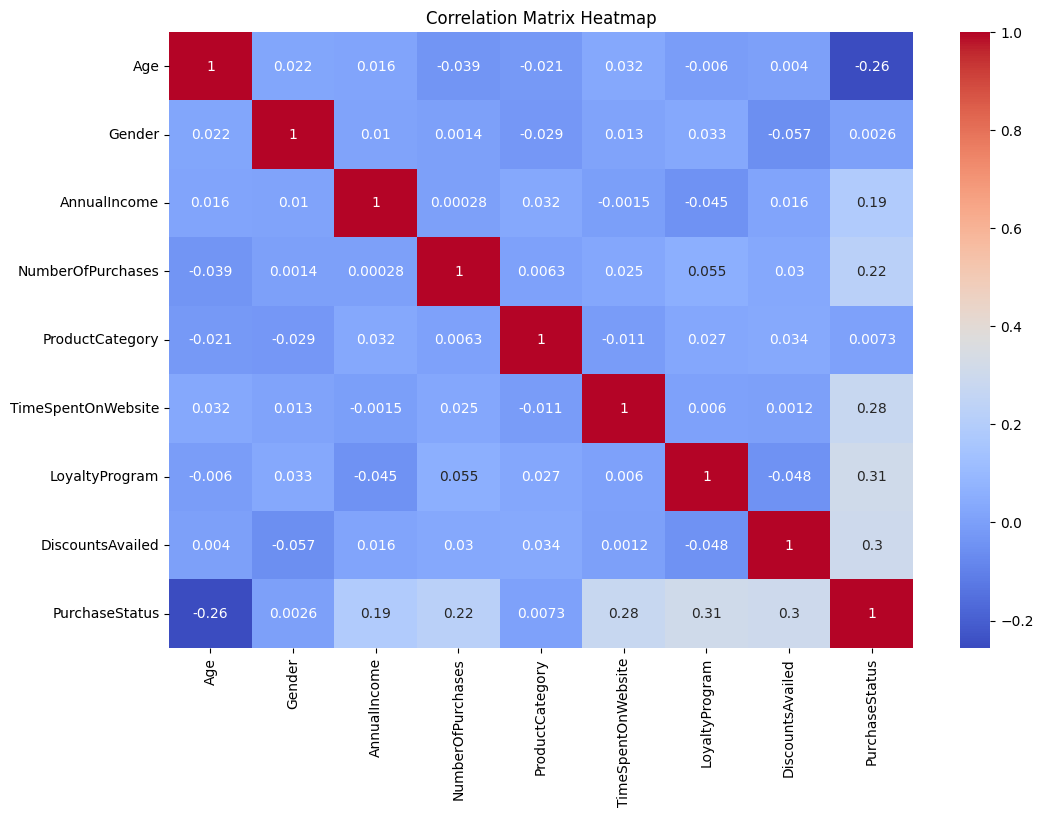

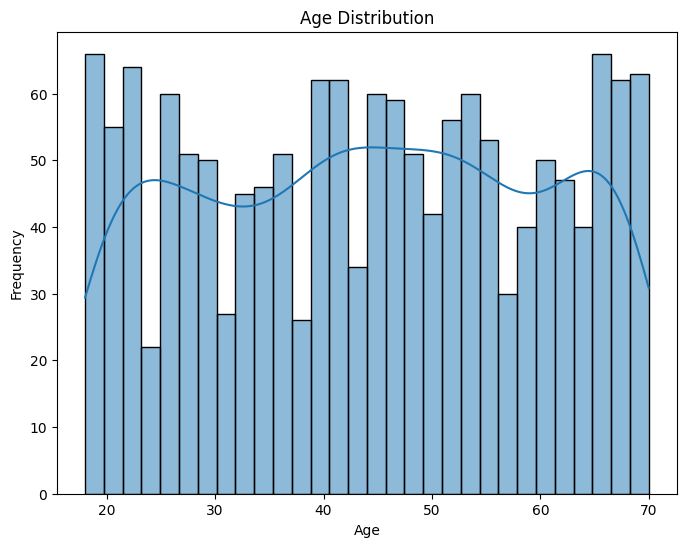

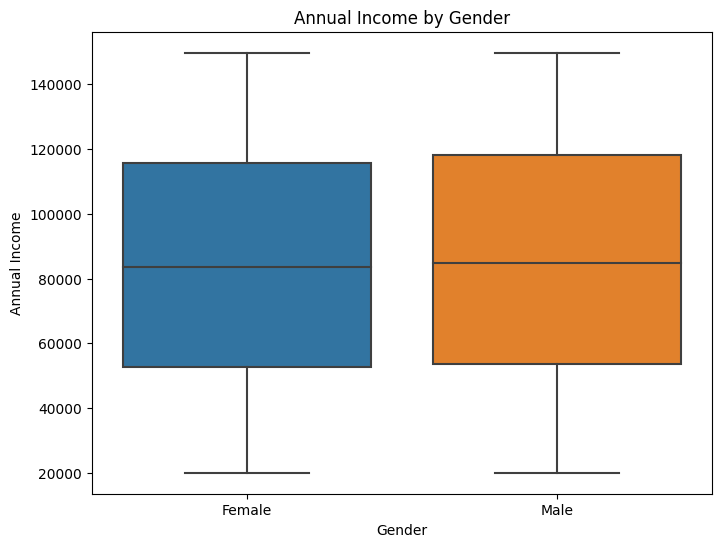

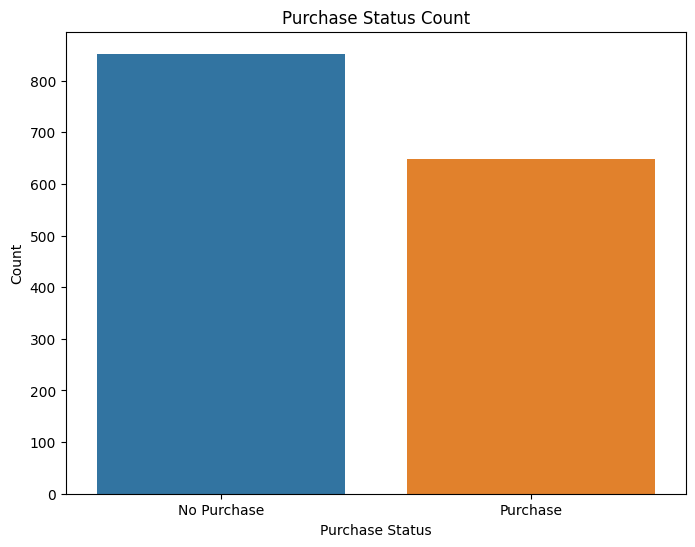

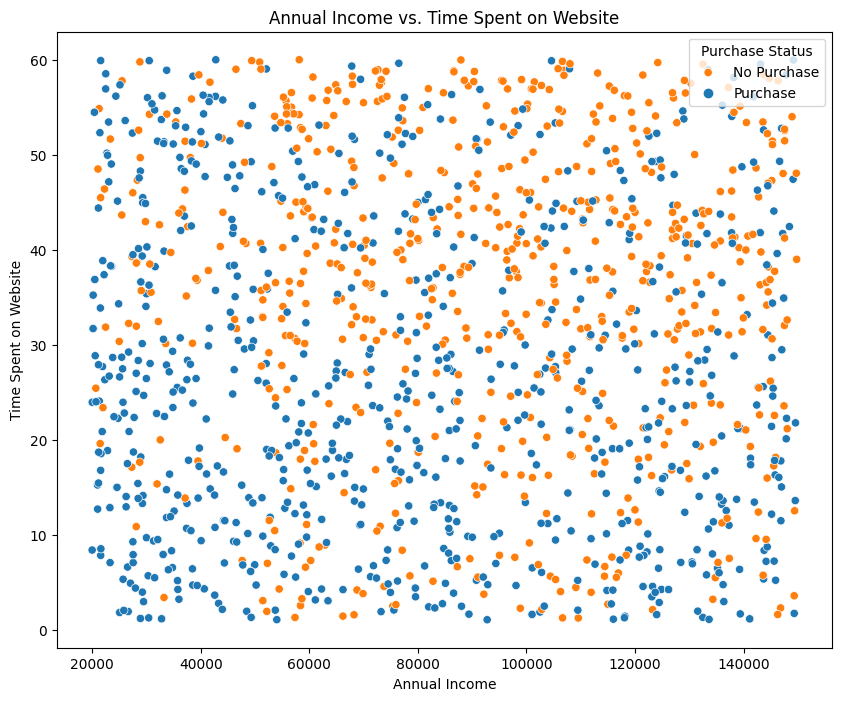

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='AnnualIncome', data=df)
plt.title('Annual Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Annual Income')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='PurchaseStatus', data=df)
plt.title('Purchase Status Count')
plt.xlabel('Purchase Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Purchase', 'Purchase'])
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='AnnualIncome', y='TimeSpentOnWebsite', hue='PurchaseStatus', data=df)
plt.title('Annual Income vs. Time Spent on Website')
plt.xlabel('Annual Income')
plt.ylabel('Time Spent on Website')
plt.legend(title='Purchase Status', labels=['No Purchase', 'Purchase'])
plt.show()


In [7]:
inputs, test_inputs, targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
inputs, meta_inputs, targets, meta_targets = train_test_split(inputs, targets, test_size=0.5, random_state=42, shuffle=True)
inputs=np.array(inputs)
targets=np.array(targets)
test_inputs=np.array(test_inputs)
test_targets=np.array(test_targets)
meta_inputs=np.array(meta_inputs)
meta_targets=np.array(meta_targets)

### Step 3: Create XGBoost Model

In [8]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    eval_metric='mlogloss'
)

### Step 4: Predict Prediction Intervals using delete-d Jackknife

In [9]:
config={
    'alpha':0.05,
    'd-value':10
}

In [10]:
y_xgb,y_pred_xgb, y_lb_xgb, y_ub_xgb = jackknife_predict(xgb_model,inputs,targets,test_inputs, config)

### Step 5: Analyse some of the results

In [11]:
data = {
    'Prediction Interval': [f"[{round(lb, 3)}, {round(ub, 3)}]" for lb, ub in zip(y_lb_xgb, y_ub_xgb)],
    'Predict XGB': y_pred_xgb,
    'Delta': [round(ub - lb, 3) for lb, ub in zip(y_lb_xgb, y_ub_xgb)],
    'Target Class':test_targets
}
df = pd.DataFrame(data)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(df)

    Prediction Interval  Predict XGB  Delta  Target Class
0        [0.681, 0.907]     0.825512  0.226             1
1        [0.002, 0.004]     0.003057  0.002             0
2        [0.024, 0.067]     0.039705  0.042             0
3        [0.006, 0.018]     0.011573  0.012             0
4        [0.982, 0.996]     0.989000  0.013             1
5        [0.002, 0.006]     0.003975  0.004             0
6        [0.969, 0.992]     0.982491  0.023             1
7        [0.221, 0.448]     0.319818  0.227             0
8        [0.004, 0.014]     0.008312  0.010             0
9        [0.002, 0.003]     0.002246  0.002             0
10        [0.99, 0.996]     0.993858  0.006             1
11       [0.827, 0.948]     0.897973  0.122             1
12       [0.029, 0.082]     0.050216  0.053             0
13        [0.03, 0.113]     0.055422  0.083             0
14       [0.983, 0.994]     0.988725  0.011             1
15       [0.007, 0.014]     0.009902  0.007             0
16       [0.99

In [12]:
y_pred = np.round(y_pred_xgb).astype(int)
incorrect_indices = np.where(y_pred != test_targets)[0]

In [13]:
data = {
    'Lower Bound XGB': y_lb_xgb[incorrect_indices],
    'Predict XGB': y_pred_xgb[incorrect_indices],
    'Upper Bound XGB': y_ub_xgb[incorrect_indices],
    'Target Class':test_targets[incorrect_indices]
}
df = pd.DataFrame(data)
print(df)

    Lower Bound XGB  Predict XGB  Upper Bound XGB  Target Class
0          0.006703     0.010506         0.015801             1
1          0.189112     0.314419         0.508145             1
2          0.172607     0.309394         0.583876             1
3          0.915203     0.945659         0.967918             0
4          0.012347     0.025266         0.045286             1
5          0.064878     0.114159         0.182728             1
6          0.002070     0.003171         0.004715             1
7          0.529121     0.650721         0.747440             0
8          0.002794     0.007017         0.014494             1
9          0.021926     0.038232         0.056623             1
10         0.292525     0.448195         0.612909             1
11         0.394268     0.657180         0.802459             0
12         0.026743     0.049764         0.078182             1
13         0.068306     0.141243         0.240300             1
14         0.700818     0.842479        

#### Out of the 21 test instances that were incorrectly predicted, almost half of them have both classes in the prediction interval

### Step 7: D-value Comparison

In [14]:
config['d-value']=5
y_xgb_10,y_pred_xgb_10, y_lb_xgb_10, y_ub_xgb_10 = jackknife_predict(xgb_model,inputs,targets,test_inputs, config)

config['d-value']=20
y_xgb_20,y_pred_xgb_20, y_lb_xgb_20, y_ub_xgb_20 = jackknife_predict(xgb_model,inputs,targets,test_inputs, config)

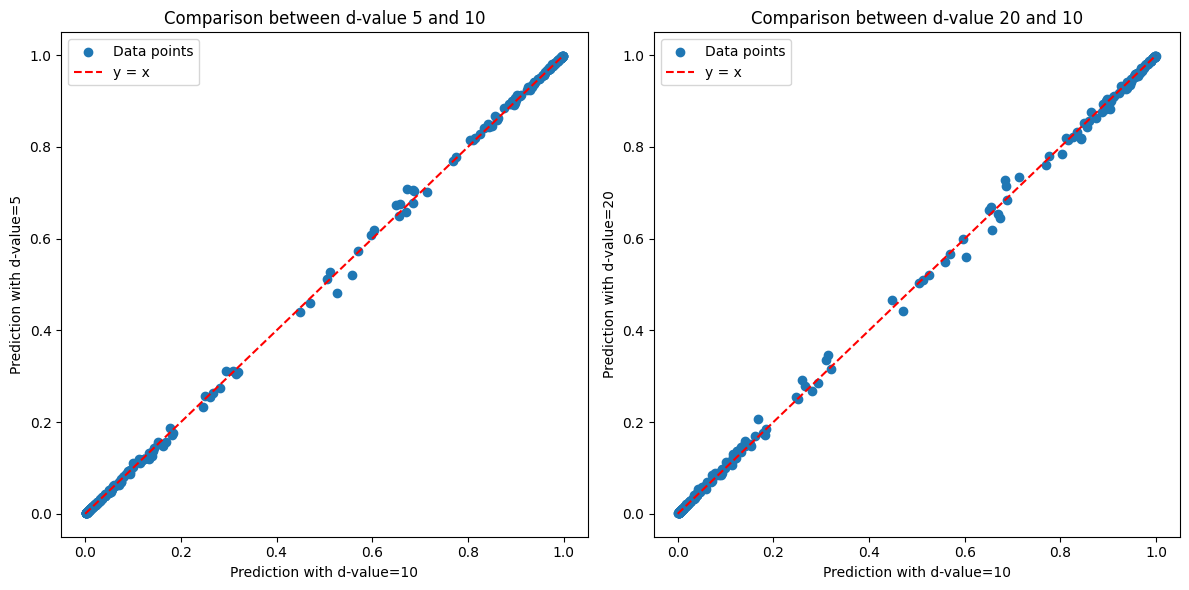

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(y_pred_xgb, y_pred_xgb_10, label='Data points')
axs[0].plot([0, 1], [0, 1], color='red', label='y = x', linestyle='--')
axs[0].set_title('Comparison between d-value 5 and 10')
axs[0].set_xlabel('Prediction with d-value=10')
axs[0].set_ylabel('Prediction with d-value=5')
axs[0].legend()

axs[1].scatter(y_pred_xgb, y_pred_xgb_20, label='Data points')
axs[1].plot([0, 1], [0, 1], color='red', label='y = x', linestyle='--')
axs[1].set_title('Comparison between d-value 20 and 10')
axs[1].set_xlabel('Prediction with d-value=10')
axs[1].set_ylabel('Prediction with d-value=20')
axs[1].legend()

plt.tight_layout()
plt.show()

### Step 8: Plot some metrics

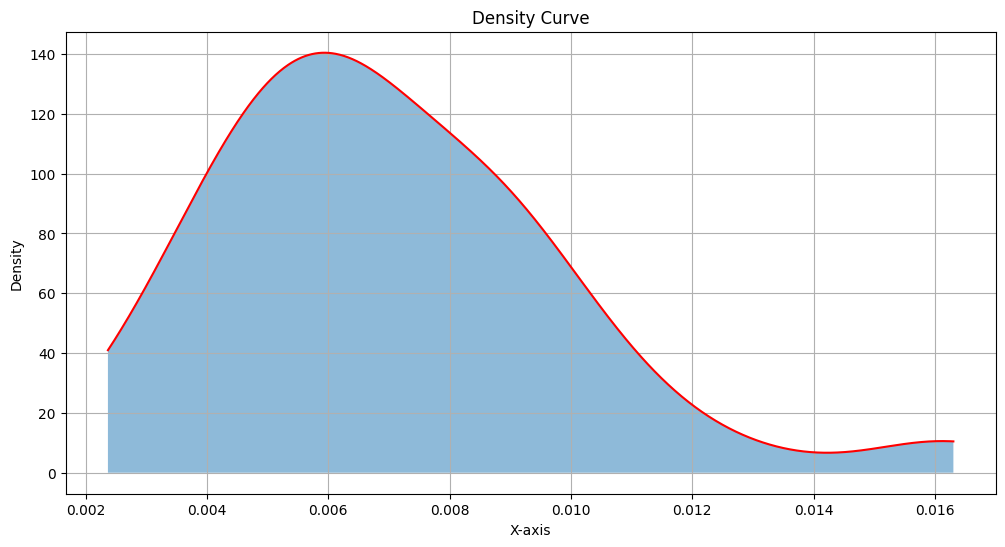

In [16]:
transposed_array = y_xgb.T
x=transposed_array[199]

density = gaussian_kde(x)
x_vals = np.linspace(min(x), max(x), 1000)
density_vals = density(x_vals)

plt.figure(figsize=(12, 6))
plt.plot(x_vals, density_vals, color='red')
plt.fill_between(x_vals, density_vals, alpha=0.5)
plt.title("Density Curve")
plt.xlabel("X-axis")
plt.ylabel("Density")
plt.grid(True)
plt.show()

### Step 9: Assess UQ Quality

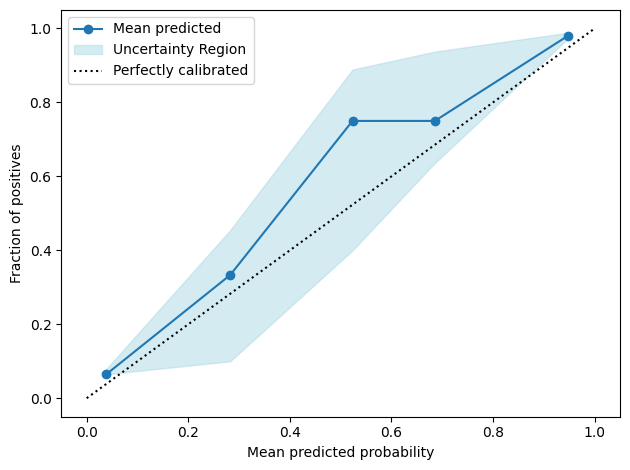

In [17]:
plot_uq_quality(test_targets,y_pred_xgb,y_ub_xgb,y_lb_xgb,bins_num=5)

## References

1. Wager, Stefan, Trevor Hastie, and Bradley Efron. "Confidence intervals for random forests: The jackknife and the infinitesimal jackknife." The journal of machine learning research 15.1 (2014): 1625-1651.
2. Giordano, Ryan, et al. "A swiss army infinitesimal jackknife." The 22nd International Conference on Artificial Intelligence and Statistics. PMLR, 2019.
3. Giordano, Ryan, Michael I. Jordan, and Tamara Broderick. "A higher-order swiss army infinitesimal jackknife." arXiv preprint arXiv:1907.12116 (2019).
4. Shao, Jun. "The efficiency and consistency of approximations to the jackknife variance estimators." Journal of the American Statistical Association 84.405 (1989): 114-119.
5. Shao, Jun, and CF Jeff Wu. "A general theory for jackknife variance estimation." The annals of Statistics (1989): 1176-1197.